In [3]:
#import machine learning libraries, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

In [4]:
#read csv as a pandas dataframe without headers
df_train = pd.read_csv('ptbdb_train.csv', header=None)
df_test = pd.read_csv('ptbdb_test.csv', header=None)

#separate last column as target for train data
data_matrix_train = df_train.values
y_train = data_matrix_train[:,-1]
X_train = data_matrix_train[:,0:-1]

#separate last column as target for test data
data_matrix_test = df_test.values
y_test = data_matrix_test[:,-1]
X_test = data_matrix_test[:,0:-1]

## Train OG Machine Learning classifiers directly on the data

In [5]:
#Train random forest and MLP classifiers on data and evaluate ROC-AUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#train random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

#train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100))

In [6]:
#Also train kNN and naive bayes classifiers for baseline comparison
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#train kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#train naive bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

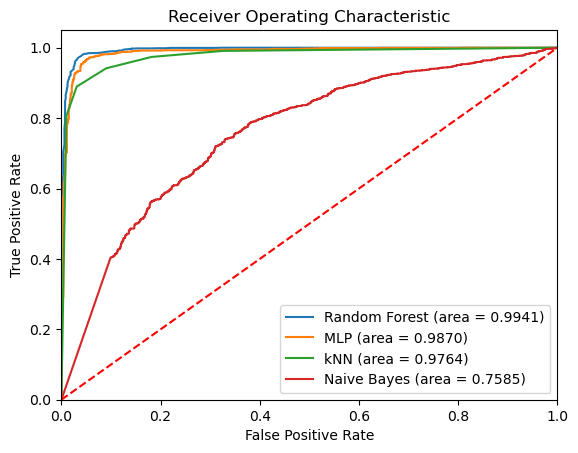

In [7]:
#predict probabilities for each classifier
y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred_mlp = mlp.predict_proba(X_test)[:,1]
y_pred_knn = knn.predict_proba(X_test)[:,1]
y_pred_nb = nb.predict_proba(X_test)[:,1]

#calculate ROC-AUC for each classifier
roc_auc_rf = metrics.roc_auc_score(y_test, y_pred_rf)
roc_auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp)
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_knn)
roc_auc_nb = metrics.roc_auc_score(y_test, y_pred_nb)

#Calculate ROC curves for each classifier
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test, y_pred_mlp)
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, y_pred_knn)
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test, y_pred_nb)

#plot ROC curves
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.4f)' % roc_auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='kNN (area = %0.4f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.4f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

# calculate confusion matrices
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test))
cm_knn = confusion_matrix(y_test, knn.predict(X_test))
cm_nb = confusion_matrix(y_test, nb.predict(X_test))

print("Confusion matrices:")
print("Random Forest")
print(cm_rf)
print("MLP")
print(cm_mlp)
print("KNN")
print(cm_knn)
print("Naive Bayes")
print(cm_nb)

#Calculate F1 score
f1_rf = metrics.f1_score(y_test, rf.predict(X_test))
f1_mlp = metrics.f1_score(y_test, mlp.predict(X_test))
f1_knn = metrics.f1_score(y_test, knn.predict(X_test))
f1_nb = metrics.f1_score(y_test, nb.predict(X_test))

print("F1 scores:")
print("Random Forest: ", f1_rf)
print("MLP: ", f1_mlp)
print("kNN: ", f1_knn)
print("Naive Bayes: ", f1_nb)



Confusion matrices:
Random Forest
[[ 737   72]
 [  25 2077]]
MLP
[[ 764   45]
 [  61 2041]]
KNN
[[ 736   73]
 [ 123 1979]]
Naive Bayes
[[ 669  140]
 [ 971 1131]]
F1 scores:
Random Forest:  0.9771818395671606
MLP:  0.9746895893027697
kNN:  0.9528165623495426
Naive Bayes:  0.6706196264453009


## Feature Engineering

In [37]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

df_train = pd.read_csv('ptbdb_train.csv', header=None)
df_test = pd.read_csv('ptbdb_test.csv', header=None)

#Separate labels from timeseries
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

#Change the dataframe so that the last column is the target
X_train = df_train.rename(columns={187: 'target'})

#Add initial id column
X_train['id'] = df_train.index

#Put all the values of a time series from a given observation in a different row, also with a index that says which observation it belongs to
X_train = pd.melt(X_train, id_vars=['id'], value_vars=df_train.columns[:-1])

X_train = X_train.sort_values(by=['id',"variable"])
X_train.head()


,id,variable,value
0,0,0,1.000000
11641,0,1,0.730599
23282,0,2,0.472859
34923,0,3,0.139526
46564,0,4,0.000000


In [40]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
                          
#extract features from train data
X_train_augmented = extract_features(X_train, column_id='id', column_sort='variable')


impute(extracted_features)
features_filtered = select_features(extracted_features, y)

Feature Extraction:   0%|          | 0/20 [00:02<?, ?it/s]


TypeError: acf() got an unexpected keyword argument 'unbiased'

: 